<a href="https://colab.research.google.com/github/aparnaashok2125/Fruit_Image_Classifier/blob/main/Fruit_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Required Libraries
!pip install tensorflow opencv-python numpy matplotlib

In [2]:
# Download and Extract Dataset
!wget -q https://github.com/Horea94/Fruit-Images-Dataset/archive/master.zip
!unzip -q master.zip
!rm master.zip

In [3]:
# Load and Preprocess Data
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
train_dir = "/content/Fruit-Images-Dataset-master/Training"
test_dir = "/content/Fruit-Images-Dataset-master/Test"

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7,1.3],
    fill_mode='nearest'
)

# Only rescaling for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [4]:
# Build the Model (Transfer Learning with ResNet50)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load ResNet50 (pre-trained on ImageNet)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Unfreeze some layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Add custom layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Add callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3)
]

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 131)            │        33,667 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,803,843 (94.62 MB)

 Trainable params: 24,749,699 (94.41 MB)

 Non-trainable params: 54,144 (211.50 KB)

In [6]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=test_generator,
    callbacks=callbacks
)

Epoch 1/5
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 1221s 577ms/step - accuracy: 0.7133 - loss: 1.3949 - val_accuracy: 0.9679 - val_loss: 0.1256 - learning_rate: 1.0000e-04
Epoch 2/5
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 1169s 552ms/step - accuracy: 0.9697 - loss: 0.1511 - val_accuracy: 0.9794 - val_loss: 0.0691 - learning_rate: 1.0000e-04
Epoch 3/5
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 1179s 557ms/step - accuracy: 0.9777 - loss: 0.0948 - val_accuracy: 0.9603 - val_loss: 0.1360 - learning_rate: 1.0000e-04
Epoch 4/5
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 1172s 554ms/step - accuracy: 0.9801 - loss: 0.0798 - val_accuracy: 0.9773 - val_loss: 0.1031 - learning_rate: 1.0000e-04
Epoch 5/5
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 1174s 555ms/step - accuracy: 0.9820 - loss: 0.0680 - val_accuracy: 0.9820 - val_loss: 0.0913 - learning_rate: 1.0000e-04


709/709 ━━━━━━━━━━━━━━━━━━━━ 65s 91ms/step


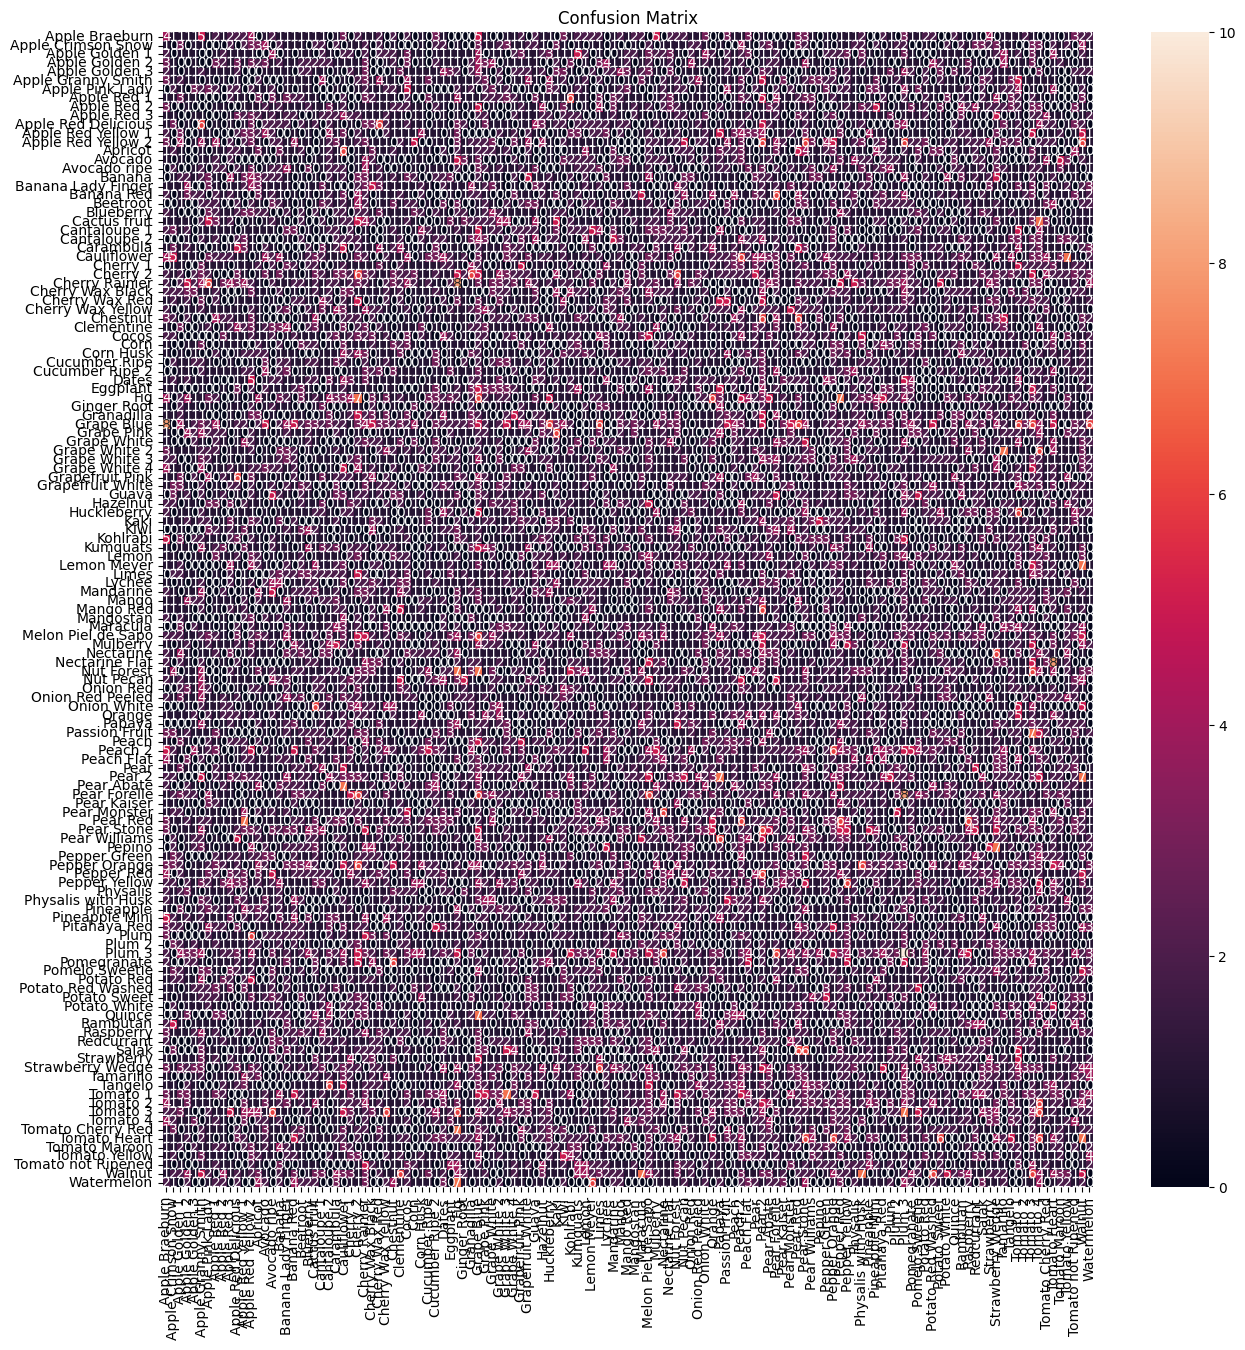

In [8]:
# Post-Training Analysis

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Generate predictions
y_true = test_generator.classes
y_pred = model.predict(test_generator).argmax(axis=1)

# Plot confusion matrix
plt.figure(figsize=(15,15))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True, fmt='d',
            xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.show()

709/709 ━━━━━━━━━━━━━━━━━━━━ 63s 89ms/step


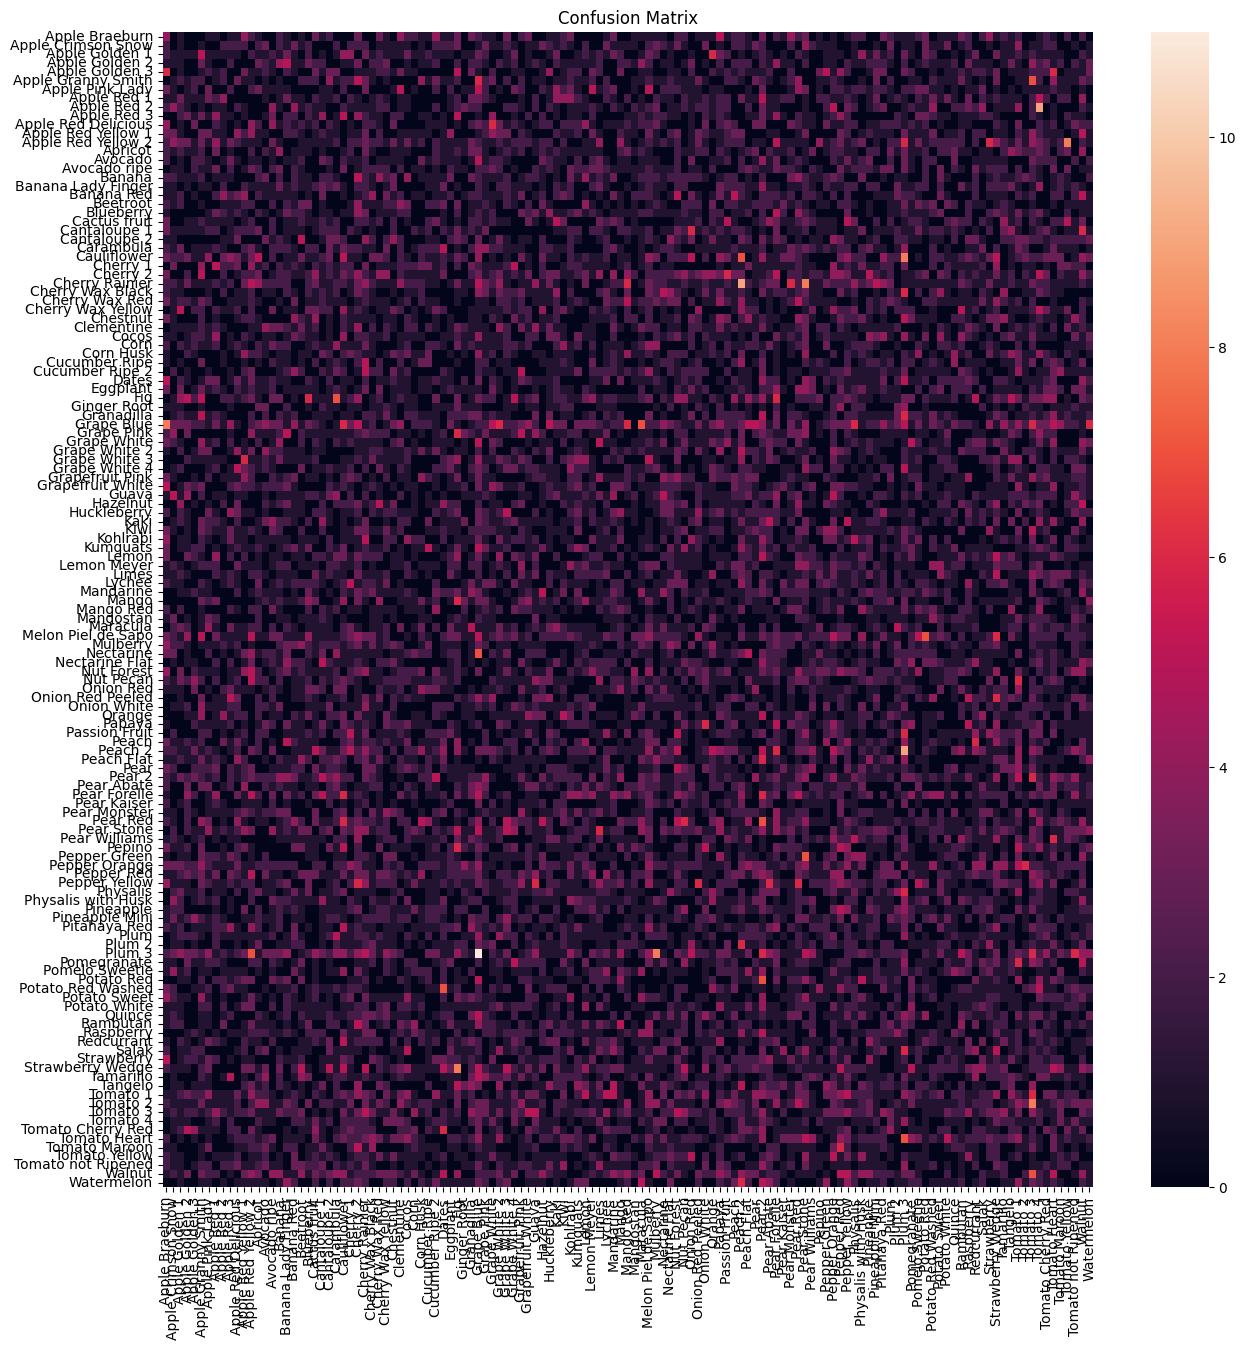

In [12]:
# Post-Training Analysis

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Generate predictions
y_true = test_generator.classes
y_pred = model.predict(test_generator).argmax(axis=1)

# Plot confusion matrix
plt.figure(figsize=(15,15))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=False, fmt='d',
            xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.show()

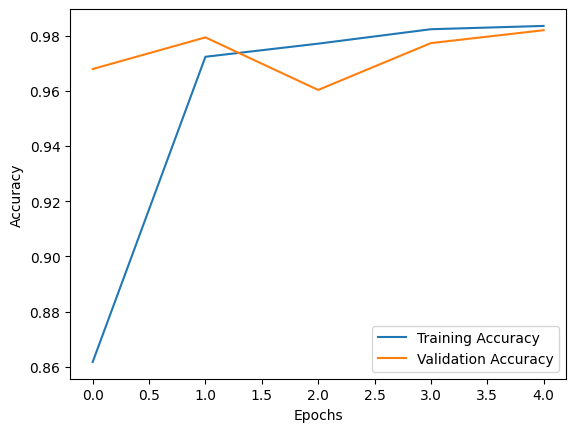

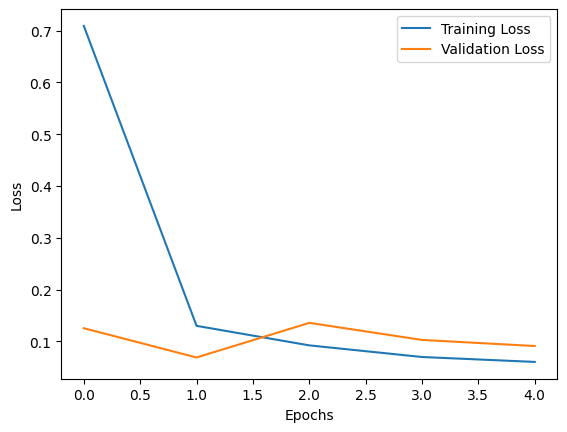

In [13]:
# Evaluate and Test

# Plot Training Accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot Training Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [14]:
# Evaluate on Test Data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

709/709 ━━━━━━━━━━━━━━━━━━━━ 64s 90ms/step - accuracy: 0.9785 - loss: 0.0713
Test Accuracy: 97.94%



Test image preview:


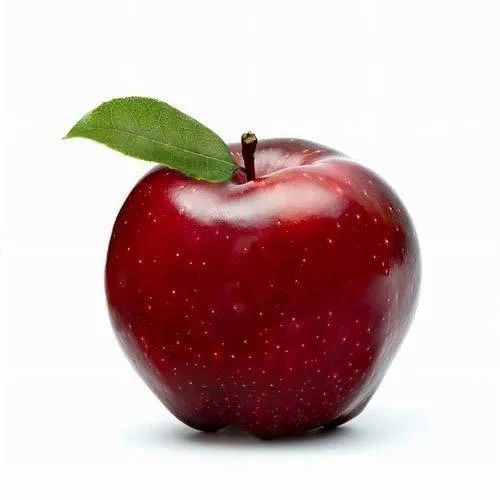

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step

Prediction result: Pear 2


In [18]:
# Prediction functions with proper error handling
import cv2
import os
import numpy as np
from urllib.request import urlretrieve
from IPython.display import Image, display

def download_test_image():
    test_url = "https://4.imimg.com/data4/BH/GH/MY-23225626/fresh-apple-1000x1000.jpg"
    test_path = "/content/test_apple.jpg"
    try:
        if os.path.exists(test_path):
            os.remove(test_path)
        urlretrieve(test_url, test_path)
        if os.path.getsize(test_path) > 0:
            return test_path
        return None
    except Exception as e:
        print(f"Download error: {str(e)}")
        return None

def predict_fruit(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError("Failed to read image")
        # Resize the image to 224x224 to match the model's input shape
        img = cv2.resize(img, (224, 224))
        img = img / 255.0
        img = np.expand_dims(img, axis=0)
        pred = model.predict(img)
        return list(train_generator.class_indices.keys())[np.argmax(pred)]
    except Exception as e:
        return f"Prediction failed: {str(e)}"

# Execute complete workflow
test_image_path = download_test_image()
if test_image_path:
    print("\nTest image preview:")
    display(Image(filename=test_image_path))
    print("\nPrediction result:", predict_fruit(test_image_path))
else:
    print("Failed to download test image")